# Creating a zero-phase speech

In this notebook we will investigate the effect of phase on the perceptual quality of a speech. It is often said that the human ear is lergely insensitive to phase and that's why most of the equalization in commercial-grade audio equipment takes place in the magnitude domain only.

But is it really so? Let's find out.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy.io import wavfile
import scipy.io.wavfile as wavfile
import scipy.io
from scipy import signal

import time
import os

import ffmpeg

import glob

## Initialization
import IPython.display as ipd

In [2]:
input_path = '_inputs/'
output_path = '_outputs/'
plt.rcParams["figure.figsize"] = (14,4)

In [3]:
def convert_signal(path):
    """
    Convert all m4a signal to wav signal in path directory
    -------------
    Parameters:
        path (string): relative path of folder where m4a iles are located
    Returns:
        None - Function will add new wav file to path directory
    -------------
    """

    for filename in os.listdir(path):
        if (filename.endswith(".m4a")) or (filename.endswith(".mp4")):
            os.system("ffmpeg -i {0} -ar 16000 {1}.wav".format(path + filename, path + filename[:-4]))
        else:
            continue

In [4]:
def read_audio(path, file_name):
    """
    Read files from specified path (relative or absolute)
    -------------
    Parameters:
        path (string): relative path to read file
        file_name (string): name of file located in path we want to read
    Returns:
        tuple: rate and date of wav file
    -------------
    """
    rate, data = wavfile.read(str(path) + str(file_name))
    data = data.astype('int16')
    return rate, data

In [5]:
def write_audio(path, sr, data):
    """
    Write audio file to path
    -------------
    Parameters:
        path (string): relative path to write file
        sr (int): sampling rate
        data (array_like): actual signal to write
    Returns:
        None
    -------------
    """
    data = data.astype('int16')
    wavfile.write(path, sr, data)
    return None

In [6]:
# Convert all test voices to wav
convert_signal(input_path)

In [7]:
Fs = 16000 # sampling freqency
TWOPI = 2 * np.pi

In [8]:
def prepare(x, max_value = 3):
    N = len(x)
    # fade-in and fade-out times max 0.2 seconds
    tf = min(int(0.2 * Fs), int(0.1 * N))
    for n in range(0, int(tf)):
        s = float(n) / float(tf)
        x[n] *= s
        x[N-n-1] *= s
    # let's append an anti-normalization tail; drawback is one second of silence in the end
    x = np.concatenate((x, np.linspace(0, max_value, int(Fs/2)), np.linspace(max_value, 0, int(Fs/2))))
    return x

By now we know that the "shape" of a waveform is largely encoded in the phase. It is no surprise, therefore, that if we mess up with the phase of the piano sample above, we will get something that looks very different.

To see this, let's take the DFT of the audio data, set the phase to zero and take the IDFT:

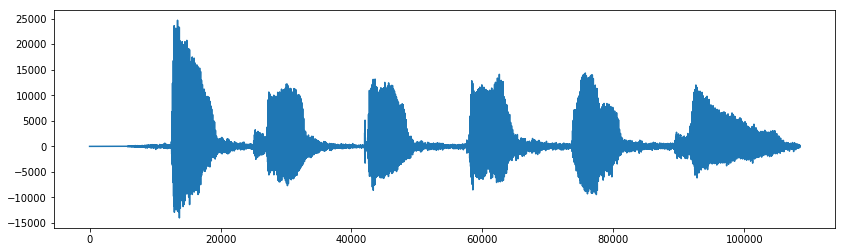

In [9]:
Fs, x = read_audio(input_path, 'Levon_Voice.wav')
plt.plot(x)
plt.show() 
IPython.display.Audio(x, rate=Fs)

In [10]:
# first some prep work; let's make sure that
#  the length of the signal is even 
#  (it will be useful later)
if len(x) % 2 != 0:
    x = x[:-1]

# let's also store the maximum value for our 
#  "prepare" function   
mv = int(max(abs(x)) * 1.2)

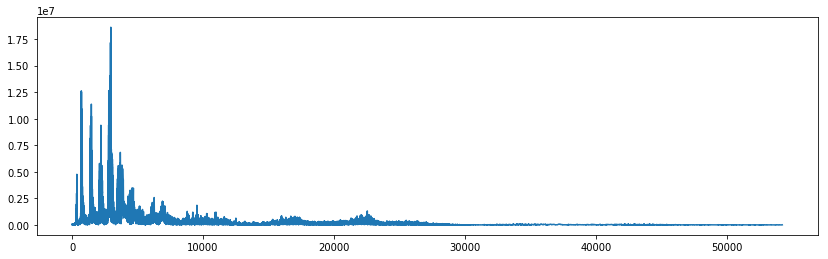

In [11]:
# Let's take the Fourier transform
X = np.fft.fft(x)

# we can plot the DFT
plt.plot(np.abs(X[0:int(len(X)/2)]))
plt.show() 

In [12]:
# now we set the phase to zero; we just need to
#  take the magnitude of the DFT
xzp = np.fft.ifft(np.abs(X))

# in theory, xzp should be real; however, because
#  of numerical imprecision, we're left with some imaginary crumbs:
print (max(np.imag(xzp)) / max(np.abs(xzp)))

6.268521387813305e-17


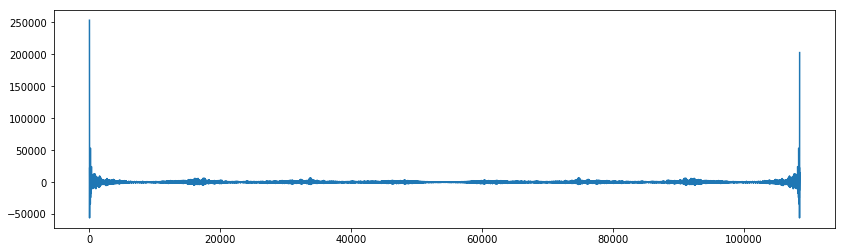

In [13]:
# the imaginary part is negligible, as expected, 
#  so let's just get rid of it
xzp = np.real(xzp)

# and now we can plot:
plt.plot(xzp)
plt.show() 

Gee, what happened?!? Well, by removing the phase, we have destroyed the timing information that, for instance, made the sharp attack possible (mathematically, note that by creating a zero-phase spectrum we did obtain a symmetric signal in the time domain!).

If we play the waveform, we can hear that the pitch and some of the timbral quality have been preserved (after all, the magnitude spectrum is the same).

In [14]:
IPython.display.Audio(prepare(xzp, mv), rate=Fs)

We can amuse ourselves with even more brutal phase mangling: let's for instance set a random phase for each DFT component. The only tricky thing here is that we need to preserve the Hermitian symmetry of the DFT in order to have a real-valued time-domain signal:

In [15]:
# we know the signal is even-length so we need to build
#  a phase vector of the form [0 p1 p2 ... pM -pM ... -p2 -p1]
#  where M = len(x)/2
ph = np.random.rand(int(len(x) / 2) ) * TWOPI * 1j
# tricky but cute Python slicing syntax...
ph = np.concatenate(([0], ph, -ph[-2::-1]))

# now let's add the phase offset and take the IDFT
xrp = np.fft.ifft(X * np.exp(ph))

# always verify that the imaginary part is only roundoff error
print (max(np.imag(xrp))/max(np.abs(xrp)))

1.1972705585622152e-07


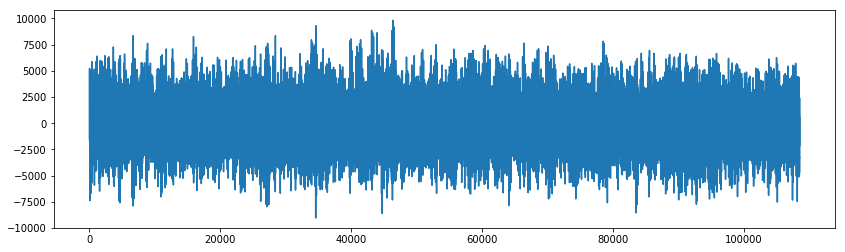

In [16]:
xrp = np.real(xrp)
plt.plot(xrp)
plt.show()

IPython.display.Audio(prepare(xrp, mv), rate=Fs)

Pretty bad, eh? So, in conclusion, phase is very important to the temporal aspects of the sound, but not so important for sustained sounds. In fact, the brain processes the temporal and spectral cues of sound very differently: when we concentrate on attacks and sound envelope, the brain uses time-domain processing, whereas for pitch and timbre, it uses primarily the magnitude of the spectrum!